In [53]:
import importlib
import intensity_opt
importlib.reload(intensity_opt)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from intensity_opt import *
import multiprocessing as mp
import trackpy as tp
from contextlib import nullcontext
from functools import partial
import pstats
import sys
sys.path.append("..")
import soren_tracking
importlib.reload(soren_tracking)


<module 'soren_tracking' from '/Users/amfaber/Documents/tracking_script/intensity_opt/../soren_tracking.py'>

In [54]:
soren_tracking.signal_extractor_no_pos(VID, DAT, "red", lip_int_size, lip_BG_size)

TypeError: signal_extractor_no_pos() got an unexpected keyword argument 'lip_int_size'

In [25]:
with mp.Pool(8) as pool:
    %timeit test = msd_df(DAT, pool=pool)

68.4 ms ± 1.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [49]:
with mp.Pool(8) as pool:
    %timeit test = pool.map(apply_numpy, DAT[["y", "x", "frame"]].to_numpy())

21.1 ms ± 469 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [48]:
s = pstats.Stats("../profile.pstats")
s.sort_stats("cumulative")
test = s.print_stats(1)

Fri Jul 15 21:05:10 2022    ../profile.pstats

         140002725 function calls (137976382 primitive calls) in 139.651 seconds

   Ordered by: cumulative time
   List reduced from 15252 to 1 due to restriction <1>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   2468/1    0.022    0.000  139.652  139.652 {built-in method builtins.exec}




In [36]:
pd.DataFrame(test, columns = ["sum", "median"])

,sum,median
0,3314,119.0
1,3176,109.0
2,3510,117.5
3,3707,120.0
4,3237,116.0
...,...,...
1340,3098,108.0
1341,3326,110.0
1342,3503,120.0
1343,3833,116.0


In [4]:
%%timeit
DAT.apply(apply_clean, axis=1)

85.6 ms ± 1.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [2]:
sig_size = 9   #originally 14 for first attempts
BG_size = 60
sqrt_BG_size = int(np.ceil(np.sqrt(BG_size)))

In [28]:
def getinds(smallmask, i_pos, j_pos):
    i_inds, j_inds = np.where(smallmask)
    i_transform = int(i_pos) - sqrt_BG_size + 1
    j_transform = int(j_pos) - sqrt_BG_size + 1
    i_inds += i_transform
    j_inds += j_transform
    out_of_bounds = i_transform < 0 or j_transform < 0 or\
                    i_transform + len(smallmask)-1 >= VID.shape[1] or\
                    j_transform + len(smallmask)-1 >= VID.shape[2]
    if out_of_bounds:
        valid = (i_inds >= 0) & (j_inds >= 0) & (i_inds < VID.shape[1]) & (j_inds < VID.shape[2])
        i_inds = i_inds[valid]
        j_inds = j_inds[valid]
    return i_inds, j_inds 

def getinds2(smallmask, i_pos, j_pos):
    i_lower = int(i_pos) - sqrt_BG_size + 1
    j_lower = int(j_pos) - sqrt_BG_size + 1
    i_upper = int(i_pos) + sqrt_BG_size + 1
    j_upper = int(j_pos) + sqrt_BG_size + 1
    out_of_bounds = i_lower < 0 or j_lower < 0 or\
                    i_upper > VID.shape[1] or\
                    j_upper > VID.shape[2]
    if out_of_bounds:
        i_inds = slice(max(i_lower, 0),
                        min(i_upper, VID.shape[1]))
        j_inds = slice(max(j_lower, 0),
                        min(j_upper, VID.shape[2]))
        smallmask_i_lower = max(-i_lower, 0)
        smallmask_j_lower = max(-j_lower, 0)
        smallmask_i_upper = min(VID.shape[1]-i_upper, 0)
        smallmask_j_upper = min(VID.shape[2]-j_upper, 0)
        smallmask_i_upper = None if smallmask_i_upper == 0 else smallmask_i_upper
        smallmask_j_upper = None if smallmask_j_upper == 0 else smallmask_j_upper
        smallmaskslice = slice(smallmask_i_lower, smallmask_i_upper), slice(smallmask_j_lower, smallmask_j_upper)
        # print(smallmaskslice)
        smallmask = smallmask[smallmaskslice]
    else:
        i_inds = slice(int(i_pos) - sqrt_BG_size + 1, int(i_pos) + sqrt_BG_size + 1)
        j_inds = slice(int(j_pos) - sqrt_BG_size + 1, int(j_pos) + sqrt_BG_size + 1)
    # i_inds, j_inds = j_inds, i_inds
    return i_inds, j_inds, smallmask
    

In [29]:
def new(i_pos, j_pos, method = 1, frame = 0):
    all_is, all_js = np.ogrid[-sqrt_BG_size-(i_pos%1)+1:+sqrt_BG_size-(i_pos%1)+1,
                    -sqrt_BG_size-(j_pos%1)+1:+sqrt_BG_size-(j_pos%1)+1]
    all_r2s = all_is**2 + all_js**2
    sig = all_r2s <= sig_size
    bg = all_r2s <= BG_size
    bg = np.logical_xor(bg, sig)

    def sort_it_out(method):
        if method == 1:
            out = np.sum(VID[(frame, *getinds(sig, i_pos, j_pos))]), np.median(VID[(frame, *getinds(bg, i_pos, j_pos))])
        elif method == 2:
            i_inds, j_inds, smallmask = getinds2(sig, i_pos, j_pos)
            try:
                out = np.sum(VID[frame, i_inds, j_inds][smallmask])
            except IndexError as e:
                print(f"{frame = }")
                print(f"{i_inds = }")
                print(f"{j_inds = }")
                print(f"{smallmask = }")
                print(f"{smallmask.shape = }")
                raise e
            i_inds, j_inds, smallmask = getinds2(bg, i_pos, j_pos)
            out = (out, np.median(VID[frame, i_inds, j_inds][smallmask]))
        return out
    out = sort_it_out(method)
    return out

def old(i_pos, j_pos):
    row = pd.Series({'x': i_pos, 'y': j_pos, "frame": 0})
    return df_extractor2(row, VID)



In [30]:
new(0, 1, method = 2)

(1440, 102.0)

In [34]:
new(100, 200)

(2997, 104.0)

In [33]:
new(100, 200, 2)

(2997, 104.0)

In [32]:
old(100, 200)

(3002, 103.0)

In [86]:
new(0, 1, 2)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 10 but corresponding boolean dimension is 9

In [46]:
def apply_to_df(row):
    return new(row.x, row.y, frame = int(row.frame), method = 2)

In [52]:
dat = DAT[["x", "y", "frame"]].to_numpy()

In [54]:
%%timeit
DAT.apply(apply_to_df, axis = 1)

92 ms ± 161 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [44]:
%%timeit
DAT.apply(df_extractor2, axis = 1, args = (VID,))

878 ms ± 12.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
DAT

,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,0,3.978723,667.133400,112.103699,1.873453,0.371781,9.647701,5839.0,0.093461,0
1,171,236.255216,399.464898,95.489277,2.005205,0.206158,7.531138,5435.0,0.207297,0
2,172,237.946100,67.402199,197.096259,2.144031,0.176617,11.468503,6077.0,0.070616,0
3,173,238.271937,78.342101,143.206413,2.152107,0.247420,8.640839,6096.0,0.069264,0
4,174,239.992463,220.958350,121.216479,2.364895,0.145883,6.570513,5820.0,0.095938,0
...,...,...,...,...,...,...,...,...,...,...
1340,1171,146.674798,347.061599,122.390753,1.897748,0.312106,9.237940,5427.0,0.212420,4
1341,1172,147.738480,390.829280,101.396521,2.128649,0.284151,6.857505,5482.0,0.181568,4
1342,1173,148.917608,26.831812,168.656189,2.428707,0.104136,6.943602,6124.0,0.067364,4
1343,1159,132.958881,27.554488,387.846815,1.957854,0.106411,25.262435,6386.0,0.053604,4


In [5]:
%%timeit
new(200, 200, 2)

43.8 µs ± 366 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [6]:
old(100,200)

(3002, 103.0)

In [7]:
new(100, 200, 1)

(3002, 103.0)

In [9]:
new(100, 200, 2)

(3002, 103.0)

In [10]:
old(VID.shape[2], VID.shape[1])

(412, 102.0)

In [11]:
new(VID.shape[2], VID.shape[1], 2)

(412, 102.0)

In [12]:
new(0,44.111,1)

(1642, 102.0)

In [70]:
new(0, 44.111, 2)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 16 but corresponding boolean dimension is 9

In [38]:
for x in np.linspace(0, VID.shape[2], 10):
    for y in np.linspace(0, VID.shape[1], 10):
        oldres = old(x, y)
        newres = new(y, x, 1)
        if not ((oldres[0] == newres[0]) and (oldres[1] == newres[1])):
            print(x, y)
            print(oldres)
            print(newres)
            print()
            # break
    # break

In [111]:
new(100, 200, 2)

(3002, 103.0)

In [112]:
new(0, 44.111111111111114, 1)

(1642, 102.0)

In [110]:
new(0, 44.111111111111114, 2)

(1646, 102.0)

In [109]:
old(0, 44.111111111111114)

(1642, 102.0)

In [161]:
x, y = 0,0

In [162]:
print(new(x, y))
df_extractor2(pd.Series({"x": x, "y": y, "frame": 0}), VID)

(1138, 102.0)


(1138, 102.0)

(3002, 103.0)

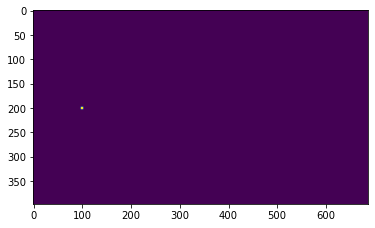

In [70]:
plt.imshow(mymask)

In [88]:
np.all(mymask == oldmask)

True

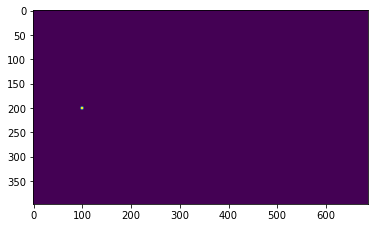

In [71]:
plt.imshow(oldmask)

In [38]:
DAT.iloc[:2].apply(test, axis=1)

Unnamed: 0       0.000000
y                3.978723
x              667.133400
mass           112.103699
size             1.873453
ecc              0.371781
signal           9.647701
raw_mass      5839.000000
ep               0.093461
frame            0.000000
Name: 0, dtype: float64
Unnamed: 0     171.000000
y              236.255216
x              399.464898
mass            95.489277
size             2.005205
ecc              0.206158
signal           7.531138
raw_mass      5435.000000
ep               0.207297
frame            0.000000
Name: 1, dtype: float64


0    None
1    None
dtype: object

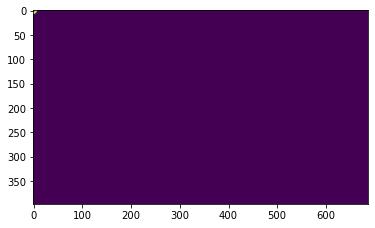

In [535]:
plt.imshow(old(0,0))

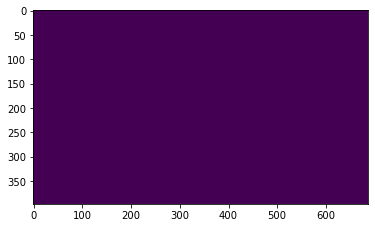

In [533]:
plt.imshow(new(0,0))

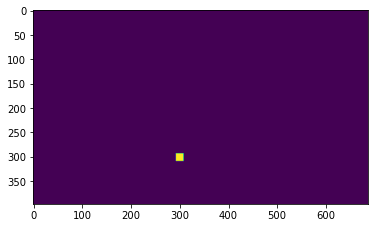

In [539]:
plt.imshow(new(300, 300))

In [537]:
check_equal(300, 300)

False

In [493]:
%%timeit
old(300, 300)

602 µs ± 1.93 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [421]:
xin = 0
yin = 2.8

In [526]:
testing = np.random.random((100,2))
testing[:, 0] *= VID.shape[2]-1
testing[:, 1] *= VID.shape[1]-1

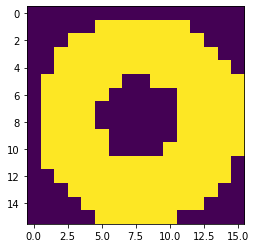

In [354]:
plt.imshow(bg)

In [326]:
int(xin)-(sqrt_BG_size-1)

297

In [334]:
int(xin) + sqrt_BG_size +1

313

In [339]:
int(xin)

304

In [338]:
list(range(int(xin)-(sqrt_BG_size-1), int(xin) + sqrt_BG_size +1))[7]

304

In [333]:
x[15]

array([7.2])

In [266]:
dat = np.linspace(0, 1, 100)

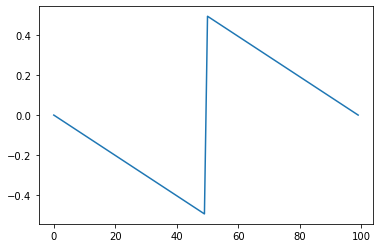

In [242]:
plt.plot(-dat + np.round(dat))

In [93]:
%%timeit
test = [make_ogrid(*tup, VID) for tup in DAT[["x", "y"]].to_numpy()]
test = list(zip(*test))
idk1, idk2 = np.stack(test[0]), np.stack(test[1])
idk1**2 + idk2**2
pass

997 ms ± 40 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [124]:
%%timeit
test = [getr2(*tup, VID) for tup in DAT[["x", "y"]].to_numpy()]
pass

658 ms ± 68.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [123]:
test

[array([[4.45082804e+05, 4.43749537e+05, 4.42418270e+05, ...,
         3.00312427e+02, 3.35045627e+02, 3.71778826e+02],
        [4.45075846e+05, 4.43742580e+05, 4.42411313e+05, ...,
         2.93354981e+02, 3.28088180e+02, 3.64821380e+02],
        [4.45070889e+05, 4.43737622e+05, 4.42406355e+05, ...,
         2.88397535e+02, 3.23130734e+02, 3.59863934e+02],
        ...,
        [5.97183570e+05, 5.95850303e+05, 5.94519036e+05, ...,
         1.52401079e+05, 1.52435812e+05, 1.52472545e+05],
        [5.97964613e+05, 5.96631346e+05, 5.95300079e+05, ...,
         1.53182121e+05, 1.53216854e+05, 1.53253588e+05],
        [5.98747655e+05, 5.97414388e+05, 5.96083122e+05, ...,
         1.53965164e+05, 1.53999897e+05, 1.54036630e+05]]),
 array([[215388.73206335, 214590.80226647, 213794.8724696 , ...,
         136776.75099791, 137346.82120103, 137918.89140415],
        [214917.22163182, 214119.29183494, 213323.36203806, ...,
         136305.24056637, 136875.31076949, 137447.38097261],
        [2144

In [107]:
DAT[["x", "y"]].to_numpy()

array([[667.13340018,   3.9787231 ],
       [399.46489844, 236.25521577],
       [ 67.40219871, 237.94610008],
       ...,
       [ 26.8318121 , 148.91760769],
       [ 27.55448786, 132.95888077],
       [153.96473848, 323.12869701]])

In [117]:
getr2(0,0,VID)

(397, 687)

In [91]:
idk1.shape

(1345, 1, 687)

In [43]:
test = np.dstack([make_ogrid(*tup, VID) for tup in DAT[["x", "y"]].to_numpy()])
pass

/opt/anaconda3/envs/tracking-script/lib/python3.8/site-packages/numpy/core/shape_base.py:191: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


In [44]:
test

(1, 2, 1345)

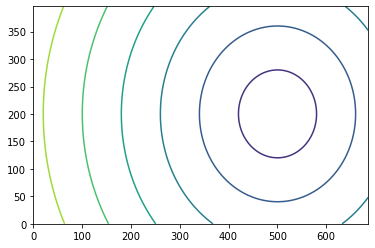

In [36]:
plt.contour(np.sqrt(x**2 + y**2))

In [21]:
frame_data[["x", "y"]].to_numpy()

array([[238.46516912, 246.98413586],
       [126.21117002, 247.34224023],
       [342.47680136, 246.07580493],
       [251.05487939, 244.4723427 ],
       [335.85836224, 243.12409182],
       [296.48386537, 242.26246468],
       [ 78.34210101, 238.2719373 ],
       [220.95835005, 239.99246315],
       [ 67.40219871, 237.94610008],
       [399.46489844, 236.25521577],
       [107.55377114, 237.20792474],
       [224.19266377, 250.83035412],
       [ 53.17867089, 241.99399907],
       [108.15592088, 249.53080815],
       [108.98881723, 319.54723341],
       [325.38701789, 251.5708333 ],
       [275.20487027, 253.29574719],
       [ 70.02065722, 253.50187135],
       [379.06177974, 253.55477651],
       [361.41424615, 255.38958319],
       [150.29073052, 256.10268949],
       [ 46.54237542, 259.27036708],
       [211.56224495, 259.43227067],
       [321.48690137, 260.10576822],
       [281.26771384, 260.71610841],
       [166.83382294, 262.04662916],
       [241.7942788 , 262.37782255],
 

In [ ]:
def intensity_bg_exctration(df, video):
    